#### Classification des données permettant de prédire si un flux réseau est une attaque ou non

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Traitement des données du fichier pickle

In [2]:
# Load the pickle file into a dataframe
df = pd.read_pickle('data/all_flow_data.pkl')

# df = df.dropna() # Drop rows with any NaN values in the DataFrame

# Split the dataframe into two based on the "protocolName" column
df_HTTPWeb = df[df['appName'] == 'HTTPWeb']
df_SSH = df[df['appName'] == 'SSH']

# # Print the shapes of the resulting dataframes
print(f'Shape of HTTPWeb dataframe: {df_HTTPWeb.shape}')
print(f'Shape of SSH dataframe: {df_SSH.shape}')

# print(df.head())

Shape of HTTPWeb dataframe: (547347, 59)
Shape of SSH dataframe: (9697, 59)


Visualisation des données

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df_HTTPWeb.head()

,appName,sourcePort,destinationPort,origin,duration,start_year,stop_year,start_month,stop_month,start_day,stop_day,direction_L2L,direction_L2R,direction_R2L,direction_R2R,protocolName_icmp_ip,protocolName_tcp_ip,protocolName_udp_ip,sourceCategory_MulticastNetwork,sourceCategory_PrivateNetwork,sourceCategory_PublicNetwork,destinationCategory_MulticastNetwork,destinationCategory_PrivateNetwork,destinationCategory_PublicNetwork,destinationCategory_UnknownNetwork,sourcePortCategory_WellKnownPorts,sourcePortCategory_RegisteredPorts,sourcePortCategory_DynamicPrivatePorts,destinationPortCategory_WellKnownPorts,destinationPortCategory_RegisteredPorts,destinationPortCategory_DynamicPrivatePorts,totalSourceBytesCategory_Small,totalSourceBytesCategory_Medium,totalSourceBytesCategory_Large,totalDestinationBytesCategory_Small,totalDestinationBytesCategory_Medium,totalDestinationBytesCategory_Large,totalSourcePacketsCategory_Low,totalSourcePacketsCategory_Medium,totalSourcePacketsCategory_High,totalDestinationPacketsCategory_Low,totalDestinationPacketsCategory_Medium,totalDestinationPacketsCategory_High,tag_Attack,sourceTCPFlag_F,destinationTCPFlag_F,sourceTCPFlag_S,destinationTCPFlag_S,sourceTCPFlag_R,destinationTCPFlag_R,sourceTCPFlag_P,destinationTCPFlag_P,sourceTCPFlag_A,destinationTCPFlag_A,sourceTCPFlag_N/A,destinationTCPFlag_N/A,protocolName_igmp,protocolName_ip,protocolName_ipv6icmp
8,HTTPWeb,3097,80,TestbedSatJun12Flows.xml,0,2010,2010,6,6,12,12,0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,1,0,0.0,0.0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,NaN,NaN,NaN
9,HTTPWeb,3096,80,TestbedSatJun12Flows.xml,0,2010,2010,6,6,12,12,0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0,0,1.0,0.0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,NaN,NaN,NaN
15,HTTPWeb,3515,80,TestbedSatJun12Flows.xml,39,2010,2010,6,6,12,12,0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0,1,0.0,0.0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,NaN,NaN,NaN
17,HTTPWeb,3094,80,TestbedSatJun12Flows.xml,0,2010,2010,6,6,12,12,0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0,0,1.0,0.0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,NaN,NaN,NaN
19,HTTPWeb,3093,80,TestbedSatJun12Flows.xml,0,2010,2010,6,6,12,12,0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0,0,1.0,0.0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,NaN,NaN,NaN


Affichage des valeurs NaN dans le dataframe

In [29]:
# Check for NaN values in the DataFrame
# nan_counts = df_HTTPWeb.isna().sum()
# print("Number of NaN values in each column:")
# print(nan_counts)

# Supprimer les colonnes à soucis
# df_HTTPWeb = df_HTTPWeb.drop(columns=['appName', 'origin'], axis=1)
# df_HTTPWeb.fillna(0, inplace=True) # Remplacez toutes les valeurs NaN par 0 dans l'ensemble du DataFrame

# df_SSH = df_SSH.drop(columns=['appName', 'origin'], axis=1)
# df_SSH.fillna(0, inplace=True) # Remplacez toutes les valeurs NaN par 0 dans l'ensemble du DataFrame

Classification des données avec validation croisée (cross-validation) de 5 folds

In [29]:
# Pour stocker les metrics de chaque tâche
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Utilisez le classificateur de votre choix
# classifier = KNeighborsClassifier(n_neighbors=5) # KNN avec k = 5
# classifier = GaussianNB() # Naive Bayes
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42) # Random Forest classification
# classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42) # multilayer perceptron

X = df_HTTPWeb.drop(['tag_Attack'], axis=1)
y = df_HTTPWeb['tag_Attack']

# Utilisation de StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
i = 0
for train_index, test_index in skf.split(X, y):
    i += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrainez le classificateur
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Calculez et stockez la précision pour cette tâche
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Afficher les mesures d'évaluation pour cette 
    print("---- Metrics for task", i, "----")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")

# Calculez la moyenne des mesures d'évaluation
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
print("==== Average metrics for all tasks ====")
print(f"Accuracy: {average_accuracy}")
print(f"Precision: {average_precision}")
print(f"Recall: {average_recall}")
print(f"F1: {average_f1}")

---- Metrics for task 1 ----
Accuracy: 0.9978715629852928
Precision: 0.7349537037037037
Recall: 0.9937402190923318
F1: 0.8449767132401863


d:\apps\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


---- Metrics for task 2 ----
Accuracy: 0.9997533570841326
Precision: 0.9693251533742331
Recall: 0.9890453834115805
F1: 0.9790859798605732
---- Metrics for task 3 ----
Accuracy: 0.9994244946057788
Precision: 0.9767827529021559
Recall: 0.9231974921630094
F1: 0.9492344883158743
---- Metrics for task 4 ----
Accuracy: 0.9955603869588651
Precision: 0.8089430894308943
Recall: 0.31191222570532917
F1: 0.45022624434389147
---- Metrics for task 5 ----
Accuracy: 0.9947656414144643
Precision: 0.8586956521739131
Recall: 0.12363067292644757
F1: 0.2161422708618331
==== Average metrics for all tasks ====
Accuracy: 0.9974750886097066
Precision: 0.8697400703169802
Recall: 0.6683051986597397
F1: 0.6879331393244718


Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    108830
           1       0.86      0.12      0.22       639

    accuracy                           0.99    109469
   macro avg       0.93      0.56      0.61    109469
weighted avg       0.99      0.99      0.99    109469

Matrice de confusion :
[[108817     13]
 [   560     79]]
Vrais Positifs : 79
Faux Positifs : 13
Vrais Négatifs : 108817
Faux Négatifs : 560


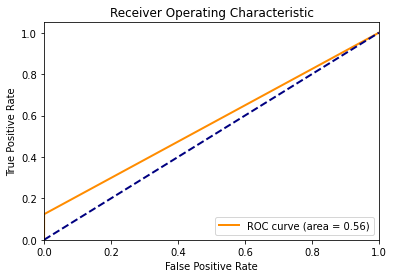

In [30]:
classification_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report)

# y_test représente vos vraies étiquettes.
# y_pred représente les étiquettes prédites par votre modèle.
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)
print(f"Vrais Positifs : {conf_matrix[1, 1]}")
print(f"Faux Positifs : {conf_matrix[0, 1]}")
print(f"Vrais Négatifs : {conf_matrix[0, 0]}")
print(f"Faux Négatifs : {conf_matrix[1, 0]}")

# Calculer les taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2  # Largeur de la ligne
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Diagonale de chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Classification des données avec train_test_split

In [36]:
# Utilisez le classificateur de votre choix
# classifier = KNeighborsClassifier(n_neighbors=5)
# classifier = GaussianNB() # Naive Bayes
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42) # Random Forest classification
# classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42) # multilayer perceptron

X = df_HTTPWeb.drop(['tag_Attack'], axis=1)
y = df_HTTPWeb['tag_Attack']
# X = df_SSH.drop(['tag_Attack'], axis=1)
# y = df_SSH['tag_Attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Entrainez le classificateur
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
    
# Calculez et stockez la précision pour cette tâche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred)

# Afficher les mesures d'évaluation
print("==== Metrics ====")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

==== Metrics ====
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       507
           1       1.00      1.00      1.00      1433

    accuracy                           1.00      1940
   macro avg       1.00      1.00      1.00      1940
weighted avg       1.00      1.00      1.00      1940

Matrice de confusion :
[[ 507    0]
 [   0 1433]]
Vrais Positifs : 1433
Faux Positifs : 0
Vrais Négatifs : 507
Faux Négatifs : 0


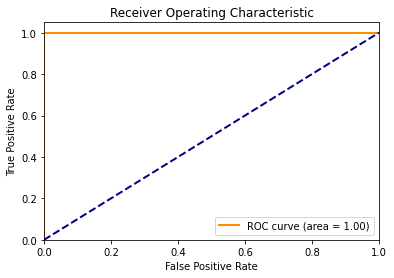

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

classification_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report)

# y_test représente vos vraies étiquettes.
# y_pred représente les étiquettes prédites par votre modèle.
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)
print(f"Vrais Positifs : {conf_matrix[1, 1]}")
print(f"Faux Positifs : {conf_matrix[0, 1]}")
print(f"Vrais Négatifs : {conf_matrix[0, 0]}")
print(f"Faux Négatifs : {conf_matrix[1, 0]}")

# Calculer les taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2  # Largeur de la ligne
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Diagonale de chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

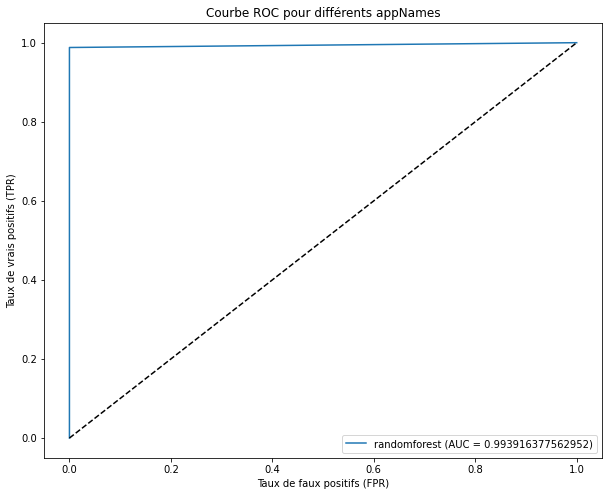

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'randomforest (AUC = ' + str(roc_auc) + ")")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC pour différents appNames')
plt.legend(loc='lower right')
plt.show() 

In [38]:
import pickle

# Enregistrer le modèle entraîné dans un fichier
# with open('challenge1/random_forest_classifier_HTTPWeb.pkl', 'wb') as file:
# with open('challenge1/random_forest_classifier_SSH.pkl', 'wb') as file:
#     pickle.dump(classifier, file)